# 3-Layer CNN for Classifciation(Only Python)

## 1. Train데이터, Test데이터 로드하기
<data's shape>

- train_images: 60000 * 1 * 28 * 28

- train_labels: 60000 * 10

- test_images: 10000 * 1 * 28 * 28

- test_labels: 10000 * 10

In [5]:
from dataloader import Dataloader
import numpy as np

train_loader = Dataloader(path="./", is_train = True, shuffle=True)
test_loader = Dataloader(path="./", is_train = False, shuffle=True)

train_images = train_loader.images
train_labels = train_loader.labels
test_images = test_loader.images
test_labels = test_loader.labels

In [6]:
# normalization: 0과 1사이로 정규화 시키기
x_train = train_images/255.
x_test = test_images/255.

y_train = train_labels
y_test = test_labels

(60000, 1, 28, 28)
(10000, 1, 28, 28)
(60000, 10)
(10000, 10)


## 2. Sub-Modules 구현 

im2col: 4차원 mnist data를 2차원으로 만들어준다.(반복문을 도는 것보다 빠르다.)

         (batch, channel, filter_h, filter_w, out_h, out_w) -> (batch*out_h,out_w, channel*filter_h*filter_w)

col2im: 2차원 data를 4차원으로 만들어준다.(역과정)

         (batch*out_h,out_w, channel*filter_h*filter_w) -> (batch, channel, filter_h, filter_w, out_h, out_w) 

In [7]:
def im2col(input_data, filter_h, filter_w, stride, pad):
    """입력 이미지를 행렬로 펼치는 함수"""
    N, C, H, W = input_data.shape
    out_h = (H + 2 * pad - filter_h) // stride + 1
    out_w = (W + 2 * pad - filter_w) // stride + 1

    img = np.pad(input_data, [(0, 0), (0, 0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride * out_h
        for x in range(filter_w):
            x_max = x + stride * out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N * out_h * out_w, -1)
    return col

def col2im(col, input_shape, filter_h, filter_w, stride, pad):   
    """행렬을 다시 이미지로 변환하는 함수"""
    N, C, H, W = input_shape
    out_h = (H + 2 * pad - filter_h) // stride + 1
    out_w = (W + 2 * pad - filter_w) // stride + 1

    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)
    img = np.zeros((N, C, H + 2 * pad + stride - 1, W + 2 * pad + stride - 1))

    for y in range(filter_h):
        y_max = y + stride * out_h
        for x in range(filter_w):
            x_max = x + stride * out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

conv: 2차원으로 변형시켜서 연산을 하고 다시 4차원으로 복구한다.

In [ ]:
class conv:
    def __init__(self, input_shape, filter_size, num_filters, stride, padding, learning_rate):
        self.batch, self.channel, self.H, self.W = input_shape
        self.filter_size = filter_size
        self.num_filters = num_filters
        self.stride = stride
        self.pad = padding
        self.learning_rate = learning_rate

        self.h_out = (self.H - self.filter_size + 2 * self.pad) // stride + 1
        self.w_out = (self.W - self.filter_size + 2 * self.pad) // stride + 1
       
        # He 방식으로 초깃값 설정(ReLU방식에 최적화된 초기화 방법)
        self.filter = (np.sqrt(2 / (self.channel * self.filter_size * self.filter_size))*np.random.randn(self.num_filters,self.channel,self.filter_size,self.filter_size))
        self.bias = (np.sqrt(2 / (self.channel * self.filter_size * self.filter_size))*np.random.randn(self.batch, self.num_filters,self.W,self.H)).reshape(self.W*self.H*self.batch,self.num_filters)

    def forward(self, input):
        self.col = im2col(input, self.filter_size, self.filter_size, self.stride, self.pad)  # 해당 층의 input을 2차원 행렬로 변화시킨 것
        self.col_W = self.filter.reshape(self.num_filters, -1).T  #weight를 2차원 행렬로 변화시킨 것
        out = np.dot(self.col, self.col_W) + self.bias

        out = out.reshape(self.batch, self.h_out, self.w_out, -1).transpose(0, 3, 1, 2)
        return out

    def backward(self, input, output_gradient):
        output_gradient = output_gradient.transpose(0, 2, 3, 1).reshape(-1, self.num_filters)
        filter_gradient = np.dot(self.col.T, output_gradient)
        filter_gradient = filter_gradient.transpose(1, 0).reshape(self.num_filters, self.channel, self.filter_size, self.filter_size)

        dcol = np.dot(output_gradient, self.col_W.T) #input gradient 구하기 위한 과정
        input_gradient = col2im(dcol, input.shape, self.filter_size, self.filter_size, self.stride, self.pad)

        bias_gradient = np.sum(output_gradient, axis=0)

        # 가중치 및 바이어스 업데이트
        self.filter -= self.learning_rate * filter_gradient
        self.bias -= self.learning_rate * bias_gradient

        return input_gradient

maxpooling: 2차원으로 변형시켜서 연산을 하고 다시 4차원으로 복구한다. back propagation은 원본 크기로 확대한 다음 원래 최댓값이 있던 자리에 gradient를 넣어준다.

In [ ]:
class maxpooling:
    def forward(self, input, filter_size=2):
        # 입력의 차원: (batch, channel, height, width)
        self.input_shape = input.shape
        batch, channel, height, width = input.shape
        
        # 출력 크기 계산
        out_height = height // filter_size
        out_width = width // filter_size

        # im2col로 변환
        self.col = im2col(input, filter_size, filter_size, filter_size, 0)
        self.col = self.col.reshape(-1, filter_size * filter_size)
        
        # 각 패치의 최대값 찾기
        max_idx = np.argmax(self.col, axis=1)
        output = self.col[np.arange(self.col.shape[0]), max_idx].reshape(batch, channel, out_height, out_width)
        
        # 역전파 시 사용할 최대값의 위치를 저장
        self.max_idx = max_idx
        return output

    def backward(self, input, output_gradient, filter_size=2):
        batch, channel, height, width = self.input_shape
        input_gradient = np.zeros(((batch * channel * height * width) // (filter_size**2), filter_size * filter_size)) #max값을 찾기 위해 한행을 필터 사이즈만큼 펼쳤기 때문에 크기를 맞추어 주기.
        
        # 역전파 시, 각 패치에서 최대값이 있었던 위치로 기울기 전달
        input_gradient[np.arange(self.max_idx.size), self.max_idx] = output_gradient.flatten() # 2차원 리스트 인덱스로 접근하는방식이랑 비슷.

        # col2im으로 다시 입력의 원래 크기로 변환
        input_gradient = col2im(input_gradient, self.input_shape, filter_size, filter_size, filter_size, 0)
        return input_gradient

In [ ]:

class linear():
    def __init__(self,learning_rate, input_size, output_size=10):
        self.learning_rate = learning_rate
        self.weight = np.random.randn(input_size, output_size)*1/np.sqrt(input_size)
        self.bias = np.zeros((1,output_size))*1/np.sqrt(input_size)

    def forward(self, input):
        batch, channel, height, width = input.shape
        n_input= input.reshape(batch,-1)
        return np.dot(n_input, self.weight) + self.bias
    
    def backward(self, input, output_gradient):
        batch, channel, height, width = input.shape
        n_input = input.reshape(batch, -1)
        
        weight_gradient = np.dot(n_input.T, output_gradient)
        bias_gradient = np.sum(output_gradient, axis=0, keepdims=True)
        input_gradient = np.dot(output_gradient, self.weight.T).reshape(input.shape)

        self.weight -= self.learning_rate * weight_gradient
        self.bias -= self.learning_rate * bias_gradient

        return input_gradient

    
class ReLU():
    def forward(self, input):
        return np.maximum(0, input)

    def backward(self, input, output_gradient):
        grad = input > 0
        return grad * output_gradient


In [ ]:
class CNN:
    def __init__(self, batch_size, learning_rate):
        # 네트워크의 계층 초기화
        # Conv Layer 1: (batch, 1, 28, 28) -> (batch, 2, 28, 28)
        # MaxPooling: (batch, 2, 28, 28) -> (batch, 2, 14, 14)
        self.conv1 = conv(input_shape=(batch_size, 1, 28, 28), filter_size=3, num_filters=2, stride=1, padding=1, learning_rate=learning_rate)
        self.relu1 = ReLU()
        self.pool1 = maxpooling() 
        # Conv Layer 2: (batch, 2, 14, 14) -> (batch, 4, 14, 14)
        # MaxPooling: (batch, 4, 14, 14) -> (batch, 4, 7, 7)
        self.conv2 = conv(input_shape=(batch_size, 2, 14, 14), filter_size=3, num_filters=4, stride=1, padding=1, learning_rate=learning_rate)
        self.relu2 = ReLU()
        self.pool2 = maxpooling()
        # Fully connected (Linear) Layer: (batch, 4*7*7) -> (batch, 10)
        self.fc = linear(learning_rate=0.001, input_size=4*7*7, output_size=10)

    def forward(self, input):
        self.inputs=[0]*7
        self.inputs[0]=input

        self.inputs[1] = self.conv1.forward(self.inputs[0])
        self.inputs[2] = self.relu1.forward(self.inputs[1])
        self.inputs[3] = self.pool1.forward(self.inputs[2], filter_size=2)

        self.inputs[4] = self.conv2.forward(self.inputs[3])
        self.inputs[5] = self.relu2.forward(self.inputs[4])
        self.inputs[6] = self.pool2.forward(self.inputs[5], filter_size=2)
 
        output= self.fc.forward(self.inputs[6])  
        return output
    
    def backward(self,  output_gradient):
        inputs = self.inputs
        output_gradient = self.fc.backward(inputs[6], output_gradient)  
        output_gradient = self.pool2.backward(inputs[5], output_gradient, filter_size=2)  
        output_gradient = self.relu2.backward(inputs[4], output_gradient)  
        output_gradient = self.conv2.backward(inputs[3], output_gradient)  
        
        output_gradient = self.pool1.backward(inputs[2], output_gradient, filter_size=2)
        output_gradient = self.relu1.backward(inputs[1], output_gradient)
        output_gradient = self.conv1.backward(inputs[0], output_gradient)
 


In [8]:
def SoftMax(output):
    output -= np.max(output, axis=1, keepdims=True) # outlier 제거
    exp_output = np.exp(output)
    softmax_values = exp_output / np.sum(exp_output, axis=1, keepdims=True)
    return softmax_values

class CE_Loss():
    def forward(y_pred, y_true):
        y_pred = np.clip(y_pred, 1e-15, 1-1e-15)  # log값이 0이 되어 발산하는 거 방지
        loss = -np.sum(y_true*np.log(y_pred), axis=1)
        return np.mean(loss)  # 그냥 loss 출력해도 되지만 epoch당 loss를 알아보기 위해서
    
    def backward(y_pred, y_true):
        dz = y_pred-y_true
        return dz

## 3. Train Pipeline과 Test Pipeline 구현

In [9]:
def CNN_train(model, x_train, y_train, batch_size, train_loss):
    num_iters = x_train.shape[0] // batch_size
    tmp_loss=[]
    indices = np.random.permutation(x_train.shape[0])
    for i in range(num_iters):
        batch_indices = indices[i*batch_size:(i+1)*batch_size]
        x_batch = x_train[batch_indices,:,:,:]
        y_batch = y_train[batch_indices,:]
        
        # forward하면서 node값 구하기
        output = model.forward(x_batch)
        
        # softmax를 이용해 output을 확률값으로 변환
        y_pred = SoftMax(output)

        # Cross entropy loss 계산
        loss = CE_Loss.forward(y_pred, y_batch)
        tmp_loss.append(loss)

        # back propagation을 하기 위해 전체 loss를 output을 미분
        output_gradient = CE_Loss.backward(y_pred,y_batch)
        # back_propagation을 하면서 weight업데이트
        model.backward(output_gradient)
    train_loss.append(sum(tmp_loss)/len(tmp_loss))

def CNN_test(model, x_test, y_test ,batch_size, test_loss):
    accuracy_list=[]
    num_iters = x_test.shape[0] // batch_size
    indices = np.random.permutation(x_test.shape[0])
    tmp_loss=[]
    for i in range(num_iters):
        batch_indices = indices[i*batch_size:(i+1)*batch_size]
        x_batch = x_test[batch_indices,:,:,:]
        y_batch = y_test[batch_indices,:]
        y_pred = SoftMax(model.forward(x_batch))
        loss = CE_Loss.forward(y_pred, y_batch)
        tmp_loss.append(loss)
        
        correct_count = np.sum(np.argmax(y_pred,axis=1)==np.argmax(y_batch, axis=1))
        accuracy = correct_count/x_batch.shape[0]
        accuracy_list.append(accuracy)
    test_loss.append(sum(tmp_loss)/len(tmp_loss))
    return sum(accuracy_list)/len(accuracy_list)

## 4. 모델 학습하기

In [10]:
# Hyper parameter 정의
batch_size = 100
epochs = 100
learning_rate = 0.001
model = CNN(batch_size, learning_rate)

train_loss = []
test_loss = []

for i in range(epochs):
    CNN_train(model, x_train, y_train, batch_size, train_loss)
    print(i+1,'Epoch Finished', end = '\t')
    print(f"Accuracy : {round(100*CNN_test(model, x_test, y_test,batch_size,test_loss),2)}%", end='\t')  # batch 사이즈 관련해서 수정해야 겠다.
    print(f"train loss: {round(train_loss[i],4)} test loss: {round(test_loss[i],4)}")

1 Epoch Finished	Accuracy : 89.55%	train loss: 0.6973 test loss: 0.3512
2 Epoch Finished	Accuracy : 92.17%	train loss: 0.3344 test loss: 0.2647
3 Epoch Finished	Accuracy : 92.75%	train loss: 0.2783 test loss: 0.2361
4 Epoch Finished	Accuracy : 93.42%	train loss: 0.2474 test loss: 0.213
5 Epoch Finished	Accuracy : 93.44%	train loss: 0.2326 test loss: 0.2022
6 Epoch Finished	Accuracy : 94.29%	train loss: 0.22 test loss: 0.1898
7 Epoch Finished	Accuracy : 93.48%	train loss: 0.2099 test loss: 0.2106
8 Epoch Finished	Accuracy : 94.11%	train loss: 0.2085 test loss: 0.1842
9 Epoch Finished	Accuracy : 94.55%	train loss: 0.2031 test loss: 0.1773
10 Epoch Finished	Accuracy : 94.14%	train loss: 0.197 test loss: 0.1874
11 Epoch Finished	Accuracy : 94.61%	train loss: 0.1939 test loss: 0.1854
12 Epoch Finished	Accuracy : 94.55%	train loss: 0.1903 test loss: 0.1758
13 Epoch Finished	Accuracy : 94.68%	train loss: 0.1876 test loss: 0.1821
14 Epoch Finished	Accuracy : 94.36%	train loss: 0.1853 test loss

# 결과물

## Result1. Loss graph 그리기

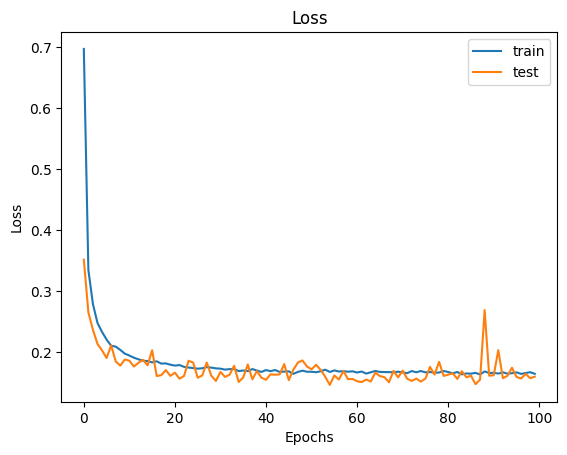

In [11]:
import matplotlib.pyplot as plt
# loss 그래프
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Result2. confusion matrix 그리기

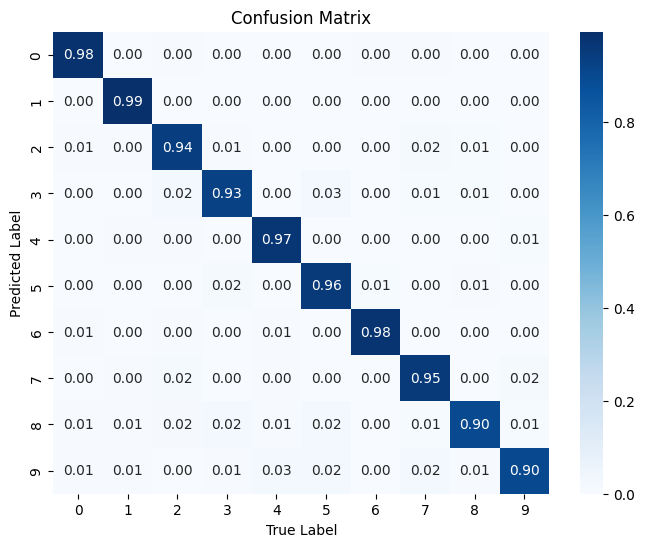

(10000, 10)
(10000, 1, 28, 28)


In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 예측값 생성
num_iters = x_test.shape[0] // batch_size
indices = np.random.permutation(x_test.shape[0])

y_pred_lst=[]
x_test_lst=[]

y_pred_classes=[]
y_true_classes=[]
for i in range(num_iters):
    batch_indices = indices[i*batch_size:(i+1)*batch_size]
    x_batch = x_test[batch_indices,:,:,:]
    y_batch = y_test[batch_indices,:]
    y_pred_tmp = SoftMax(model.forward(x_batch))
    # one-hot coding 뽑아내기(Top3 이미지 뽑기 위한 용도)
    y_pred_lst.append(y_pred_tmp.tolist())
    x_test_lst.append(x_batch.tolist())
    # 라벨값 뽑아내기
    y_pred_classes += np.argmax(y_pred_tmp, axis=1).tolist()
    y_true_classes += np.argmax(y_batch, axis=1).tolist()

y_pred = np.vstack(y_pred_lst)
x_test_img = np.vstack(x_test_lst)


# Confusion Matrix 생성 및 정규화
cm = confusion_matrix(y_true_classes, y_pred_classes, normalize='true')

# Confusion Matrix 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.xlabel('True Label')  
plt.ylabel('Predicted Label')  
plt.title('Confusion Matrix')
plt.show()


## Result3-1. Top3 images 뽑아내기

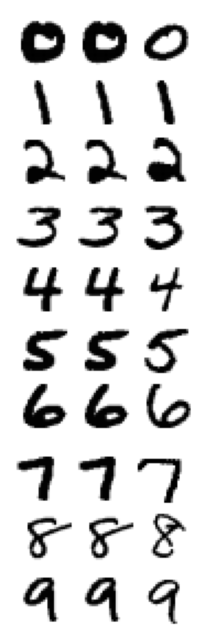

In [13]:
top3_data = [[] for _ in range(10)]

for i in range(len(y_pred)):
    for j in range(10):
        if len(top3_data[j])<3:
            top3_data[j].append((i,y_pred[i][j]))
        else:
            for k in range(3):
                if top3_data[j][k][1]<y_pred[i][j]:
                    top3_data[j].remove(min(top3_data[j], key=lambda x: x[1]))
                    top3_data[j].append((i,y_pred[i][j]))
                else:
                    continue

top3_sort = [[] for _ in range(10)]
for i in range(10):
    top3_sort[i] = sorted(top3_data[i], key= lambda x: x[1], reverse=True)

final_combined_image = None
for i in range(10):
    image1 = 1 - x_test_img[top3_sort[i][0][0]].reshape(28,28)
    image2 = 1 - x_test_img[top3_sort[i][1][0]].reshape(28,28) 
    image3 = 1 - x_test_img[top3_sort[i][2][0]].reshape(28,28) 
    combined_image = np.hstack((image1, image2, image3))
    if final_combined_image is None:
        final_combined_image = combined_image
    else:
        # 기존의 final_combined_image에 새로 연결된 이미지를 세로로 추가
        final_combined_image = np.vstack((final_combined_image, combined_image))

    # 결과 출력
plt.figure(figsize=(8, 8))
plt.imshow(final_combined_image, cmap='gray')
plt.axis('off')  # 축 숨기기
plt.show()



## Result3-2. Top3 images에 대한 확률 뽑아내기

In [14]:
for i in range(10):
    print(f"{round(top3_sort[i][0][1]*100,1)}%, {round(top3_sort[i][1][1]*100,1)}%, {round(top3_sort[i][2][1]*100,1)}%")
    print()

100.0%, 100.0%, 100.0%

100.0%, 100.0%, 100.0%

100.0%, 100.0%, 100.0%

100.0%, 100.0%, 100.0%

100.0%, 100.0%, 100.0%

100.0%, 100.0%, 100.0%

100.0%, 100.0%, 100.0%

100.0%, 100.0%, 100.0%

100.0%, 100.0%, 100.0%

100.0%, 100.0%, 100.0%

